**NOAA CalCOFI Genomics (NCOG) MetaT - Filtering ORFs belonging to Mixoplankton & ALDEX Experiment Design**

Definition of mixoplankton, [Mitra et al 2023](https://onlinelibrary.wiley.com/doi/10.1111/jeu.12972?s=03): eukaryotes that can perform
- photoautotrophy through constitutive (native to cell) photosynthetic machinery or machinery acquired from prey 
- osmoheterotrophy (taking in nutrients dissolved solution including necessary carbon)
- phagotrophy (taking in machinery and material from prey cells, by variety of feeding methods-- engulfing whole cells, sticking a feeding tube into them, lysing them with toxic metabolites)

Input files for analysis: 
- **orf_taxo_mft files from data/totalRNA/ and data/polyA/**
    - Can see how these files were created with scp & python script in data/ folder.
- **env metadata file -- need this for splits over samples**
    - NOTE THAT 

This notebook does:
- **Distributions of orf taxo mft table: what classes of organisms present, in what proportions?**
- Creating new subset tables in line with experiment design
- Creating new experiment design subtables:
    - Row select from orfhits abundance table based on "is this sample part of experiment or not" (did we actually have to do this? check code.)
    - Column select from orfhits abundance table based on "is this ORF part of experiment or not"

In [2]:
import pandas as pd
orf_taxo_mft_total = pd.read_csv("../data/totalRNA/orf_taxo_mft.tsv", sep = "\t", index_col = 0)
orf_taxo_mft_polyA = pd.read_csv("../data/polyA/orf_taxo_mft.tsv", sep = "\t", index_col = 0)

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
orf_taxo_mft_polyA.loc[orf_taxo_mft_polyA.apply(
    lambda row: row["MFT"] == "CM" and "Dinoflagellata" in row["LPI_taxonomy"], axis = 1
)]

,LPI_taxonomy,most_specific_name,MFT
ORFID,,,
contig_1000023_1_765_+,Eukaryota;Alveolata;Dinoflagellata;Dinophyceae...,Lingulodinium_polyedra,CM
contig_1000075_283_834_-,Eukaryota;Alveolata;Dinoflagellata;Dinophyceae...,Gonyaulax_spinifera,CM
contig_1000084_83_955_-,Eukaryota;Alveolata;Dinoflagellata;Dinophyceae...,Gonyaulax_spinifera,CM
contig_1000086_1_198_-,Eukaryota;Alveolata;Dinoflagellata;Dinophyceae...,Gonyaulax_spinifera,CM
contig_100012_350_1123_+,Eukaryota;Alveolata;Dinoflagellata;Dinophyceae...,Gymnodinium_catenatum,CM
...,...,...,...
contig_999836_1_276_+,Eukaryota;Alveolata;Dinoflagellata;Dinophyceae...,Tripos_fusus,CM
contig_999839_3_1073_+,Eukaryota;Alveolata;Dinoflagellata;Dinophyceae...,Protoceratium_reticulatum,CM
contig_999891_1_612_+,Eukaryota;Alveolata;Dinoflagellata;Dinophyceae...,Symbiodinium_sp,CM


In [5]:
##These are the old pr2 system. There's no "TSAR" supergroup category.
class_level = 3
class_labels_polyA = orf_taxo_mft_polyA["LPI_taxonomy"].apply(lambda x: x.split(";")[:class_level][-1]).unique()
class_label_counts_polyA = pd.Series([0] * len(class_labels_polyA), index = class_labels_polyA)

class_labels_total = orf_taxo_mft_total["LPI_taxonomy"].apply(lambda x: x.split(";")[:class_level][-1]).unique()
class_label_counts_total = pd.Series([0] * len(class_labels_total), index = class_labels_total)

#go through and fill tallies, can barh (y = index, width = value)
for taxon in orf_taxo_mft_polyA["LPI_taxonomy"]:
    label = taxon.split(";")[:class_level][-1]
    class_label_counts_polyA[label] += 1
for taxon in orf_taxo_mft_total["LPI_taxonomy"]:
    label = taxon.split(";")[:class_level][-1]
    class_label_counts_total[label] += 1

In [6]:
class_label_counts_polyA = class_label_counts_polyA.sort_values(ascending = False)
class_label_counts_total = class_label_counts_total.sort_values(ascending = False)

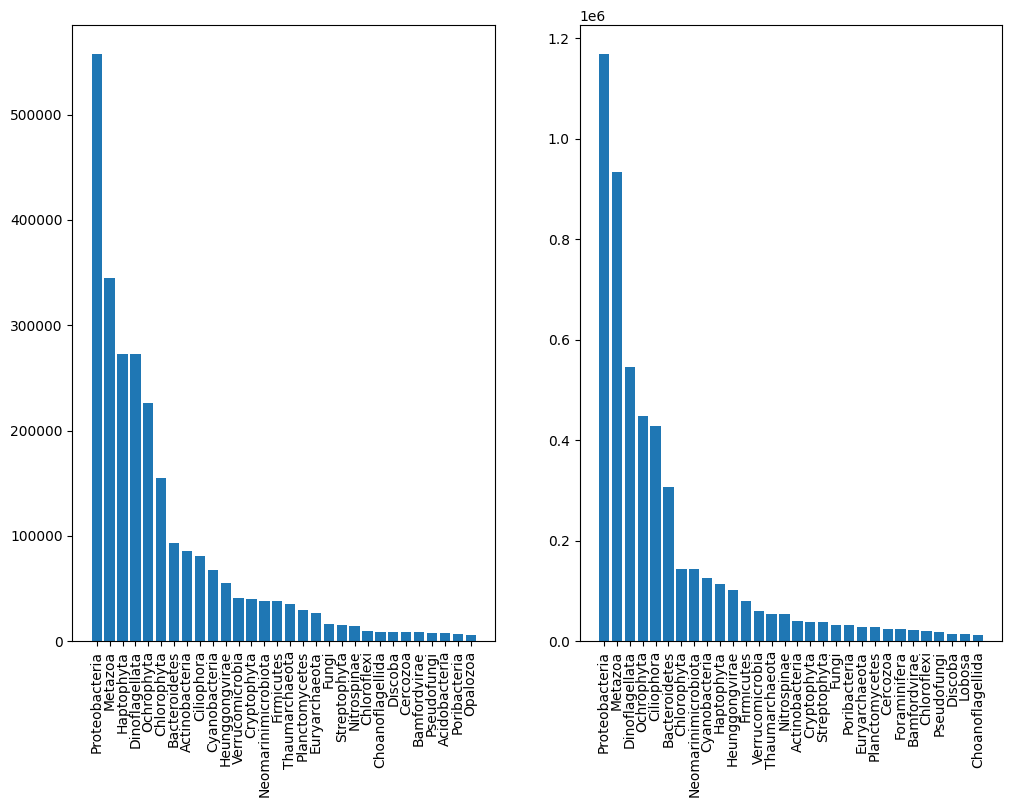

In [7]:
fig, ax = plt.subplots(1,2)
fig.set_figheight(8)
fig.set_figwidth(12)
top_x = 30
ax[0].bar(x=class_label_counts_polyA.index[:top_x], height = class_label_counts_polyA[:top_x])
ax[1].bar(x=class_label_counts_total.index[:top_x], height = class_label_counts_total[:top_x])
ax[0].tick_params(axis='x', labelrotation=90)
ax[1].tick_params(axis='x', labelrotation=90)
plt.show()

**CM distribution of ORF counts**

will likely confirm that dinos have the most transcripts.

In [8]:
CM_class_labels_polyA = orf_taxo_mft_polyA.loc[orf_taxo_mft_polyA["MFT"] == "CM", "LPI_taxonomy"].apply(
    lambda x: x.split(";")[:class_level][-1]
).unique()
CM_class_labels_total = orf_taxo_mft_total.loc[orf_taxo_mft_total["MFT"] == "CM", "LPI_taxonomy"].apply(
    lambda x: x.split(";")[:class_level][-1]
).unique()
CM_class_counts_polyA = pd.Series([0] * len(CM_class_labels_polyA), index = CM_class_labels_polyA)
CM_class_counts_total = pd.Series([0] * len(CM_class_labels_total), index = CM_class_labels_total)
for taxon in orf_taxo_mft_polyA.loc[orf_taxo_mft_polyA["MFT"] == "CM", "LPI_taxonomy"]:
    label = taxon.split(";")[:class_level][-1]
    CM_class_counts_polyA[label] += 1
for taxon in orf_taxo_mft_total.loc[orf_taxo_mft_total["MFT"] == "CM", "LPI_taxonomy"]:
    label = taxon.split(";")[:class_level][-1]
    CM_class_counts_total[label] += 1

CM_class_counts_polyA = CM_class_counts_polyA.sort_values(ascending = False)
CM_class_counts_total = CM_class_counts_total.sort_values(ascending = False)

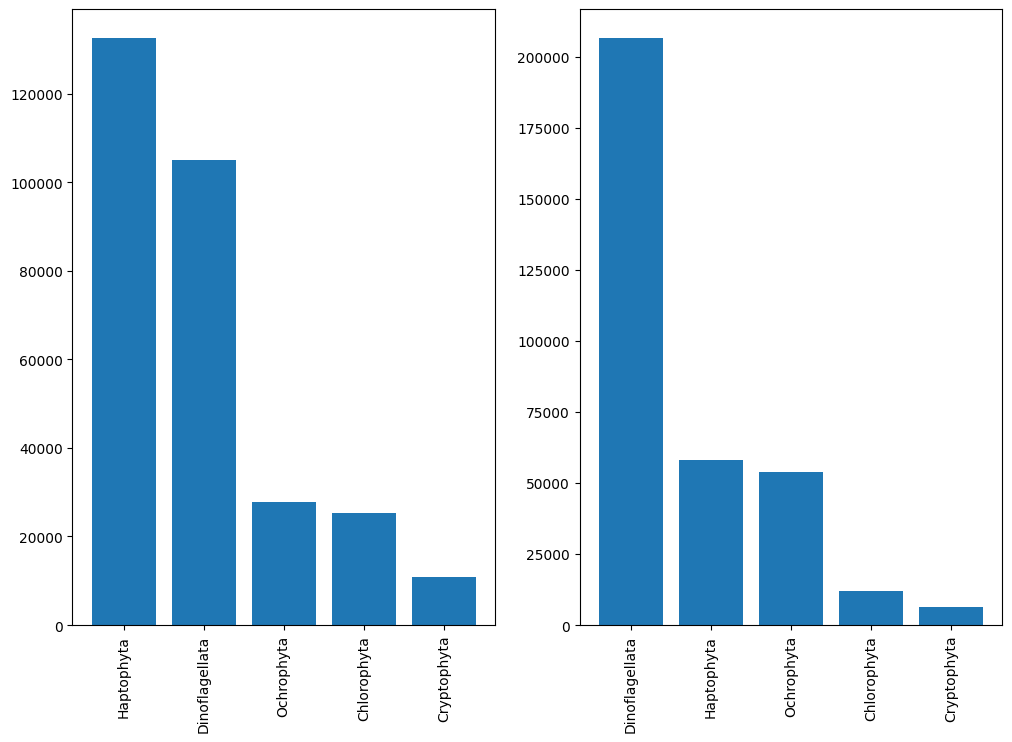

In [9]:
fig, ax = plt.subplots(1,2)
fig.set_figheight(8)
fig.set_figwidth(12)
top_x = 30
ax[0].bar(x=CM_class_counts_polyA.index[:top_x], height = CM_class_counts_polyA[:top_x])
ax[1].bar(x=CM_class_counts_total.index[:top_x], height = CM_class_counts_total[:top_x])
ax[0].tick_params(axis='x', labelrotation=90)
ax[1].tick_params(axis='x', labelrotation=90)
plt.show()

### Making Subtables

Aldex2, probably DESeq2 as well, should have only the features and samples that they need.
Subset each table by ORFs.

In [10]:
def replace_names(code):
    print(code.replace("polyA", "total"))

In [11]:
CM_orf_taxo_mft_polyA = orf_taxo_mft_polyA[orf_taxo_mft_polyA["MFT"] == "CM"]
all_CM_orfs_polyA = set(CM_orf_taxo_mft_polyA.index)
dino_CM_orfs_polyA = set(CM_orf_taxo_mft_polyA[CM_orf_taxo_mft_polyA["LPI_taxonomy"].str.contains("Dinoflagellata")].index)
hapto_CM_orfs_polyA = set(CM_orf_taxo_mft_polyA[CM_orf_taxo_mft_polyA["LPI_taxonomy"].str.contains("Haptophyta")].index)

In [12]:
CM_orf_taxo_mft_total = orf_taxo_mft_total[orf_taxo_mft_total["MFT"] == "CM"]
all_CM_orfs_total = set(CM_orf_taxo_mft_total.index)
dino_CM_orfs_total = set(CM_orf_taxo_mft_total[CM_orf_taxo_mft_total["LPI_taxonomy"].str.contains("Dinoflagellata")].index)
hapto_CM_orfs_total = set(CM_orf_taxo_mft_total[CM_orf_taxo_mft_total["LPI_taxonomy"].str.contains("Haptophyta")].index)

In [13]:
#search_species("Eukaryota;Archaeplastida;Chlorophyta;Nephroselmidophyceae;Nephroselmidophyceae_X;Nephroselmidaceae;Nephroselmis;Nephroselmis pyriformis, Strain CCMP717", debug = True)
#search_species("Eukaryota;Stramenopiles;Stramenopiles_X;Bacillariophyta;Bacillariophyta_X;Polar-centric-Mediophyceae;Thalassiosira;Thalassiosira oceanica CCMP1005", debug = True)
#search_species("Eukaryota;Opisthokonta;Metazoa;Arthropoda;Hexapoda;Insecta;Acyrthosiphon;Acyrthosiphon pisum", debug = True)
#search_species("Eukaryota;Hacrobia;Haptophyta;Prymnesiophyceae;Isochrysidales;Noelaerhabdaceae;Emiliania;Emiliania huxleyi 374", debug=True)
#search_species("Eukaryota;Hacrobia;Haptophyta;Prymnesiophyceae;Isochrysidales;Noelaerhabdaceae;Emiliania;Emiliania huxleyi CCMP1516", debug=True)
#search_species("Eukaryota;Hacrobia;Haptophyta;Prymnesiophyceae;Isochrysidales;Noelaerhabdaceae;Emiliania;Emiliania huxleyi CCMP370", debug=True)
#search_species("Eukaryota;Hacrobia;Haptophyta;Prymnesiophyceae;Phaeocystales;Phaeocystaceae;Phaeocystis;Phaeocystis antarctica, Strain CCMP1374", debug=True)

In [27]:
#matching sequences not identified by strain anymore in the new pipeline...
#mixotrophy predictions or assignments are sometimes made on this basis.
orf_taxo_mft_total["LPI_taxonomy"].str.contains("Strain").any(),\
orf_taxo_mft_polyA["LPI_taxonomy"].str.contains("Strain").any()

(False, False)

In [14]:
import os
totalRNA_path = os.path.abspath("../data/totalRNA/")
polyA_path = os.path.abspath("../data/polyA/")

def generate_subtable(infile_path, outfile_path, orf_set):
    with open(infile_path, "r") as infile:
        with open(outfile_path, "w") as outfile:
            #transfer the first line's column labels to outfile
            outfile.write(infile.readline())
            ### infile.readlines() UNPACKS THE ITERATOR! will crash if file too big
            for line in infile: 
                terms = line.split("\t")
                orf_id = terms[0]
                if orf_id in orf_set:
                    outfile.write(line)

In [29]:
#can use this method to generate both types of subtables.

generate_subtable(
    os.path.join(totalRNA_path, "NCOG-totalRNA-annotations.tsv"), 
    os.path.join(totalRNA_path, "subtables", "all_CM_annotations.tsv"),
    all_CM_orfs_total
)

generate_subtable(
    os.path.join(totalRNA_path, "NCOG-totalRNA-annotations.tsv"), 
    os.path.join(totalRNA_path, "subtables", "dino_CM_annotations.tsv"),
    dino_CM_orfs_total
)

generate_subtable(
    os.path.join(totalRNA_path, "NCOG-totalRNA-annotations.tsv"), 
    os.path.join(totalRNA_path, "subtables", "hapto_CM_annotations.tsv"),
    hapto_CM_orfs_total
)

In [28]:
generate_subtable(
    os.path.join(totalRNA_path, "annotation_all.filtered.orfhits.tab"), 
    os.path.join(totalRNA_path, "subtables", "all_CM_orfhits.tsv"),
    all_CM_orfs_total
)

generate_subtable(
    os.path.join(totalRNA_path, "annotation_all.filtered.orfhits.tab"), 
    os.path.join(totalRNA_path, "subtables", "dino_CM_orfhits.tsv"),
    dino_CM_orfs_total
)

generate_subtable(
    os.path.join(totalRNA_path, "annotation_all.filtered.orfhits.tab"), 
    os.path.join(totalRNA_path, "subtables", "hapto_CM_orfhits.tsv"),
    hapto_CM_orfs_total
)

In [21]:
generate_subtable(
    os.path.join(polyA_path, "NCOG-polyA-annotations.tsv"), 
    os.path.join(polyA_path, "subtables", "all_CM_annotations.tsv"),
    all_CM_orfs_polyA
)

generate_subtable(
    os.path.join(polyA_path, "NCOG-polyA-annotations.tsv"), 
    os.path.join(polyA_path, "subtables", "dino_CM_annotations.tsv"),
    dino_CM_orfs_polyA
)

generate_subtable(
    os.path.join(polyA_path, "NCOG-polyA-annotations.tsv"), 
    os.path.join(polyA_path, "subtables", "hapto_CM_annotations.tsv"),
    hapto_CM_orfs_polyA
)

In [23]:
generate_subtable(
    os.path.join(polyA_path, "annotation_all.filtered.orfhits.tab"), 
    os.path.join(polyA_path, "subtables", "all_CM_orfhits.tsv"),
    all_CM_orfs_polyA
)

generate_subtable(
    os.path.join(polyA_path, "annotation_all.filtered.orfhits.tab"), 
    os.path.join(polyA_path, "subtables", "dino_CM_orfhits.tsv"),
    dino_CM_orfs_polyA
)

generate_subtable(
    os.path.join(polyA_path, "annotation_all.filtered.orfhits.tab"), 
    os.path.join(polyA_path, "subtables", "hapto_CM_orfhits.tsv"),
    hapto_CM_orfs_polyA
)

In [20]:
%%bash
#filter may account for differences in size -- 100k of the mixo orfs already taken out for some reason
wc -l ../data/totalRNA/subtables/all_CM_annotations.tsv
wc -l ../data/totalRNA/subtables/all_CM_orfhits.tsv

336962 ../data/totalRNA/subtables/all_CM_annotations.tsv
240359 ../data/totalRNA/subtables/all_CM_orfhits.tsv


In [18]:
%%bash
wc -l ../data/totalRNA/annotation_all.filtered.orfhits.tab
wc -l ../data/totalRNA/NCOG-totalRNA-annotations.tsv

7267714 ../data/totalRNA/annotation_all.filtered.orfhits.tab
6943959 ../data/totalRNA/NCOG-totalRNA-annotations.tsv


In [24]:
len(all_CM_orfs_total), len(dino_CM_orfs_total), len(hapto_CM_orfs_total)

(336961, 206405, 58046)

In [25]:
len(all_CM_orfs_polyA), len(dino_CM_orfs_polyA), len(hapto_CM_orfs_polyA)

(301533, 105144, 132526)

### Experiment design: choosing admissible samples & splitting factors.

Should I still throw out shallow samples? Interesting bimodal distribution of diversity over depth w/ dino CMs, a second peak in the deep.

In [34]:
env_metadata = pd.read_csv("../data/NCOG_sample_log_RNA_metadata.tsv", sep = "\t", index_col = 0)
env_metadata["sample_number_polyA"] = env_metadata["sample_number"] + "_R1" #Run 1???
env_metadata.columns

Index(['sample_number', 'Cruise', 'Event', 'Order_Occ', 'Sta_ID', 'line',
       'station', 'Cast_Type', 'Cardinal_Sta', 'Station_Notes', 'Bottle',
       'Assoc_Bottle', 'Depthm', 'Bottle_Notes', 'NCOG_DNA', 'NCOG_RNA',
       'DNA_VolFilt', 'RNA_VolFilt', 'Pump_Speed', 'DNA_RNA_Vol_Notes',
       'Filt_Str', 'Filt_End', 'Date', 'Time', 'DateTime', 'Lat_Dec',
       'Lon_Dec', 'Distance', 'NoCCSamples', 'DelDepth', 'CC_Depth', 'T_degC',
       'Salnty', 'STheta', 'O2ml_L', 'PO4ug', 'SiO3ug', 'NO3ug', 'NH3ug',
       'ChlorA', 'Phaeop', 'RecInd', 'Code_CCE', 'IntChl', 'IntC14',
       'MLD_Sigma', 'NCDepth', 'Spike1', 'Spike8', 'depth_category',
       'sample_number_polyA'],
      dtype='object')

In [40]:
import numpy as np
def add_cols(row):
    if np.isnan(row.iloc[0]) and np.isnan(row.iloc[1]):
        return np.nan
    elif np.isnan(row.iloc[0]):
        return row.iloc[1]
    elif np.isnan(row.iloc[1]):
        return row.iloc[0]
    return sum(row)
    
env_metadata["DIN"] = env_metadata[["NO3ug", "NH3ug"]].apply(add_cols, axis = 1)
env_metadata[["NO3ug", "NH3ug", "DIN"]]

,NO3ug,NH3ug,DIN
Sample.Name,,,
201402_090.0_110.0_63,0.000000,0.05,0.050000
201402_090.0_110.0_20,0.000000,0.04,0.040000
201402_090.0_080.0_30,0.200000,0.14,0.340000
201402_090.0_080.0_10,0.200000,0.13,0.330000
201404_090.0_100.0_11,0.100000,0.28,0.380000
...,...,...,...
202010_090.0_037.0_515,39.700001,NaN,39.700001
202010_080.0_070.0_10,0.000000,NaN,0.000000
202010_080.0_070.0_40,3.690000,NaN,3.690000


In [1]:
shallow_samples = env_metadata.loc[env_metadata["depth_category"] == "Surface"]
median_temp = np.median(shallow_samples["T_degC"])
median_DIN = np.median(shallow_samples["DIN"].dropna())

def assign_factor(value, median):
    assert(not np.isnan(value)) # should have dropped NA from column this is being applied over
    return "A" if value < median else "B"

#create new input series
temp_factor_total = shallow_samples["T_degC"].rename(index = shallow_samples["sample_number"], name = "conditions").dropna().apply(
    assign_factor, median = median_temp
)
DIN_factor_total = shallow_samples["DIN"].rename(index = shallow_samples["sample_number"], name = "conditions").dropna().apply(
    assign_factor, median = median_DIN
)
temp_factor_polyA = shallow_samples["T_degC"].rename(index = shallow_samples["sample_number_polyA"], name = "conditions").dropna().apply(
    assign_factor, median = median_temp
)
DIN_factor_polyA = shallow_samples["DIN"].rename(index = shallow_samples["sample_number_polyA"], name = "conditions").dropna().apply(
    assign_factor, median = median_DIN
)

NameError: name 'env_metadata' is not defined

In [2]:
temp_factor_polyA.to_csv("temp_polyA/expdesign.tsv", sep = "\t")#, header=False)
temp_factor_total.to_csv("temp_totalRNA/expdesign.tsv", sep = "\t")#, header=False)
DIN_factor_polyA.to_csv("DIN_polyA/expdesign.tsv", sep = "\t")#, header=False)
DIN_factor_total.to_csv("DIN_totalRNA/expdesign.tsv", sep = "\t")#, header=False)

NameError: name 'temp_factor_polyA' is not defined